# 虚谷号的MQTTAPI样例——远程天气

虚谷号自带了MQTT服务器SIoT。借助这个SIoT，可以让虚谷号和其他可以访问MQTT的程序、硬件快速连接起来。比如，我们可以让掌控板发送请求当前疫情的消息，由虚谷号处理好后发送回来；可以在虚谷号存储题库，随机发送一个给掌控板；甚至让虚谷号发回一张图片，在掌控板的屏幕显示出来。

总之，我们可以把虚谷号当作一个中继的处理器，用来处理掌控板、Arduino和Mind+、Processing等软硬件不容易处理的信息。

## 1. 原理介绍

这种MQTT传播的方式，我们称之为MQTTAPI。用MQTT方式传输信息，可以用双主题的机制，一个topicID作为“收”的通道，另一个topicID作为“发”的通道。当然，也可以用单主题的机制，只不过MQTT的消息是公开广播的形式，所以消息中要加上特殊的标识，如“0”表示发送给服务器，“1”表示发送客户端。相对来说单消息机制各有利弊。

“远程天气”这个案例中，我采用了双主题的方式。“xzr/001”为客户端到服务器，即请求的信息；“xzr/002”为服务器到客户端，即反馈的信息。虽然掌控板利用mPython或者Mind+都能实现查询天气的功能，但这是一个很经典的案例，以此为例，我们可以做很多类似的应用。在天气查询的API方面，也选择了“心知天气”。

## 2. 代码范例

### 2.1. 准备工作

In [1]:
import siot
import time

### 2.2 连接服务器

In [2]:
SERVER = "127.0.0.1"        #MQTT服务器IP
CLIENT_ID = ""              #在SIoT上，CLIENT_ID可以留空
Topic1  = 'xzr/001'   #客户端到服务器
Topic2  = 'xzr/002'   #服务器到客户端
IOT_UserName ='scope'        #用户名
IOT_PassWord ='scope'     #密码
siot.init(CLIENT_ID, SERVER, user=IOT_UserName, password=IOT_PassWord)
siot.connect()

### 2.3. 设置回调函数

在回调函数“sub_cb”中，根据发送的信息，调用相应的函数。这里最好做一下判断，看消息是否正确。注意，“msg.payload”是消息的内容，类型是“bytes”，需要以utf-8编码方式来解码。

In [3]:
def sub_cb(client, userdata, msg):
    print("Topic:" + str(msg.topic) + " Message:" + str(msg.payload))
    s=str(msg.payload, encoding = "utf8") 
    get_weather(s)

查了下心知天气的文档，得到如下信息：

API地址：https://api.seniverse.com/v3/weather/now.json?key=S_zw8qq3BQPUr1wMU&location=beijing&language=zh-Hans&unit=c

那就依样画葫芦，写一个获取天气信息的函数。

In [4]:
import requests,json
API='https://api.seniverse.com/v3/weather/now.json'
KEY='S_zw8qq3BQPUr1wMU'
LANGUAGE='zh-Hans'
UNIT='c'
def fetchWeather(location):
    result = requests.get(API, params={
        'key': KEY,
        'location': location,
        'language': LANGUAGE,
        'unit': UNIT
    }, timeout=1)
    print(result)
    return result

这个API返回的信息格式如下：

{"results":[{"location":{"id":"WX4FBXXFKE4F","name":"北京","country":"CN","path":"北京,北京,中国","timezone":"Asia/Shanghai","timezone_offset":"+08:00"},"now":{"text":"晴","code":"1","temperature":"7"},"last_update":"2020-02-22T18:10:00+08:00"}]}

逐一把需要的信息取出来。

In [7]:
def get_weather(m):
    result = fetchWeather(m)
    result=result.json()
    r=result["results"][0]
    s1=r["location"]["name"] #城市名称
    s2=r["now"]["text"] #天气信息
    s3=r["now"]["temperature"] #气温
    s=s1 + '今天的天气' + s2 +'，气温'+ s3
    print(s)
    siot.publish(Topic2,s)

Topic:xzr/001 Message:b'\xe5\x8c\x97\xe4\xba\xac'
<Response [200]>
北京今天的天气晴，气温6


### 2.4. 开始监视消息

In [6]:
siot.subscribe(Topic1, sub_cb)
siot.loop()


连接结果: 连接成功 
Topic:xzr/001 Message:b'\xe5\x8c\x97\xe4\xba\xac'
<Response [200]>


当我们给SIoT的topicID“xzr/001”发送“北京”或者“beijing”，“xzr/002”就能收到“北京今天的天气晴，气温6”的消息。

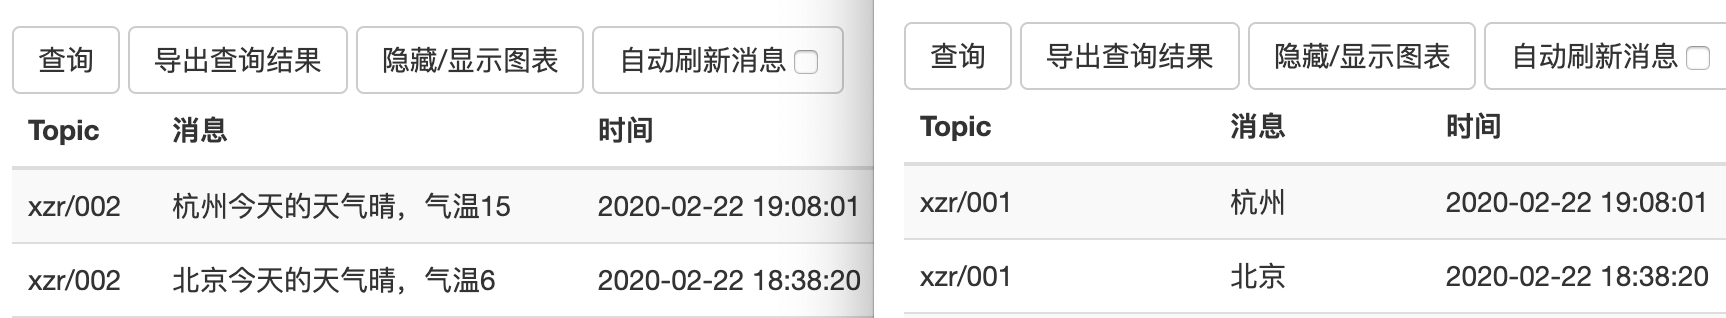

## 3. 小结

我们会发现，经过稳定的SIoT服务器中转，MQTT消息的确能够成为不同系统、不同硬件之间的“桥梁”，编程难度也不大。需要注意的是，MQTT的回调函数不会返回错误信息，给调试带来了一定的难度，需要先把函数调试成功后，再加到回调函数中。